#### __Bài tập 2:__ Phân loại MNIST bằng mạng FC (Fully Connected) với TensorFlow

#### __Giải thích code__

#### 1. Nhập các thư viện cần thiết và tải dữ liệu

In [ ]:
import numpy as np                      # numpy là thư viện cho tính toán số học và xử lý mảng đa chiều
from keras.datasets import mnist        # keras.datasets.mnist để tải bộ dữ liệu MNIST
import tensorflow as tf                 # tensorflow là thư viện mã nguồn mở cho học máy và học sâu
%matplotlib inline                      # hiển thị biểu đồ trực tiếp trong notebook

# bộ dữ liệu MNIST gồm các hình ảnh chữ số viết tay từ 0 đến 9, dữ liệu được chia thành tập huấn luyện và tập kiểm tra
(X_train, y_train), (X_test, y_test) = mnist.load_data()    

np.random.seed(0)                       # kết quả ngẫy nhiên có thể tái lặp
# chọn 50000 mẫu ngẫu nhiên từ 60000 mẫu có sẵn trong tập huấn luyện
# sử dụng np.random.choice để chọn các chỉ số mà không lặp lại (replace=False)
train_indices = np.random.choice(60000, 50000, replace=False)
# tập xác thực gồm 10000 mẫu còn lại không được chọn cho tập huấn luyện
valid_indices = [i for i in range(60000) if i not in train_indices]
# phân chia dữ liệu thành tập huấn luyện chứa 50000 mẫu, tập xác thực chứa 10000 mẫu
X_valid, y_valid = X_train[valid_indices,:,:], y_train[valid_indices]
X_train, y_train = X_train[train_indices,:,:], y_train[train_indices]

# đầu ra sẽ hiển thị kích thước của X_train, X_valid và X_test
print(X_train.shape, X_valid.shape, X_test.shape)

(50000, 28, 28) (10000, 28, 28) (10000, 28, 28)


#### 2. Tiền xử lý dữ liệu

In [ ]:
image_size = 28                 # kích thước của ảnh MNIST (28x28 pixel)
num_labels = 10                 # số lượng lớp (chữ số từ 0 đến 9)

def reformat(dataset, labels):  # chuyển đổi dữ liệu ảnh và nhãn sang định dạng phù hợp cho mô hình
  # làm phẳng mỗi ảnh từ kích thước (28, 28) thành một vector phẳng có kích thước 784
  # định dạng dữ liệu thành float32 để phù hợp với Tensorflow
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # chuyển đổi nhãn số nguyen thành vector one-hot có chiều dài 10
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
# áp dụng hàm reformat cho dữ liệu, chuyển đổi cho cả tập huấn luyện, tập xác thực và tập kiểm tra
X_train, y_train = reformat(X_train, y_train)
X_valid, y_valid = reformat(X_valid, y_valid)
# kiểm tra kích thước mới của các tập dữ liệu để đảm bảo quá trình chuyển đổi đúng
X_test, y_test = reformat(X_test, y_test)
print('Training set', X_train.shape, X_train.shape)
print('Validation set', X_valid.shape, X_valid.shape)
print('Test set', X_test.shape, X_test.shape)

Training set (50000, 784) (50000, 784)
Validation set (10000, 784) (10000, 784)
Test set (10000, 784) (10000, 784)


#### 3. Định nghĩa hàm tính độ chính xác

In [ ]:
def accuracy(predictions, labels):  # tính toán tỷ lệ phần trăm dự đoán đúng
  # sử dụng np.argmax để lấy nhãn dự đoán và nhãn thực sự, so sánh và tính tỷ lệ các dự đoán đúng trên tổng số mẫu
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

#### 4. Xây dựng mô hình TensorFlow

In [ ]:
batch_size = 256                        # kích thước của mỗi batch dữ liệu
num_hidden_units = 1024                 # số lượng neuron trong lớp ẩn
lambda1 = 0.05                          # hệ số điều chuẩn L2 để giảm overfitting
lambda2 = 0.05

tf.compat.v1.disable_eager_execution()  # tắt chế độ thực thi eager của TensorFlow
graph = tf.Graph()                      # sử dụng tf.Graph() để bắt đầu xây dựng mô hình
with graph.as_default():
  tf_train_dataset = tf.compat.v1.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))          # dữ liệu đầu vào cho batch huấn luyện
  tf_train_labels = tf.compat.v1.placeholder(tf.float32, shape=(batch_size, num_labels))  # nhãn cho batch huấn luyện
  tf_valid_dataset = tf.constant(X_valid)                                                 # dữ liệu xác thực và kiểm tra
  tf_test_dataset = tf.constant(X_test)
  
  # trọng số giữa đầu vào và lớp ẩn
  weights1 = tf.Variable(tf.random.truncated_normal([image_size * image_size, num_hidden_units]))
  biases1 = tf.Variable(tf.zeros([num_hidden_units]))                                     # bias cho lớp ẩn

  layer_1_outputs = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)           # tính toán lớp ẩn sử dụng hàm kích hoạt ReLU

  # trọng số giữa lớp ẩn và đầu ra
  weights2 = tf.Variable(tf.random.truncated_normal([num_hidden_units, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))                                           # bias cho lớp đầu ra 

  # tính toán đầu ra kết hợp tuyến tính giữa lớp ẩn và lớp đầu ra
  logits = tf.matmul(layer_1_outputs, weights2) + biases2 
  # sử dụng softmax_cross_entropy_with_logits để tính mất mát, thêm điều chuẩn L2 cho các trọng số                    
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits) + \
                        lambda1*tf.nn.l2_loss(weights1) + lambda2*tf.nn.l2_loss(weights2))  
    
  # sử dụng GradientDescentOptimizer với tốc độ học 0.003
  optimizer = tf.compat.v1.train.GradientDescentOptimizer(0.003).minimize(loss)
  # kết quả dự đoán cho batch huấn luyện, tính toán dự đoán cho cả tập xác thực và kiểm tra bằng mô hình đã xây dựng
  train_prediction = tf.nn.softmax(logits)
  layer_1_outputs = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(layer_1_outputs, weights2) + biases2)
  layer_1_outputs = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(layer_1_outputs, weights2) + biases2)  

#### 5. Huấn luyện mô hình

Initialized
Minibatch loss at step 0: 86069.718750
Minibatch accuracy: 7.0%
Validation accuracy: 38.2%


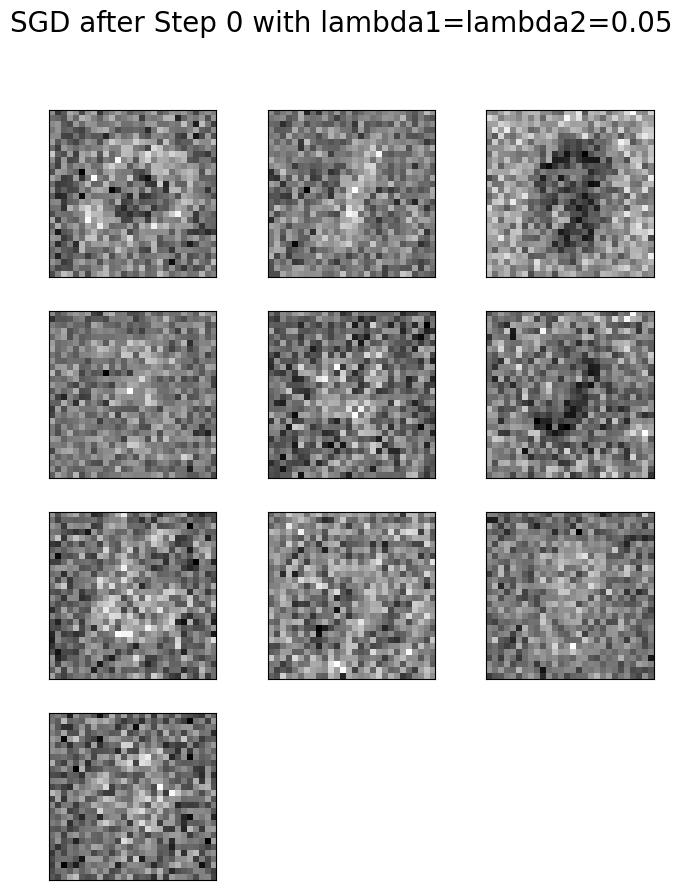

Minibatch loss at step 500: 13944.977539
Minibatch accuracy: 93.4%
Validation accuracy: 89.4%


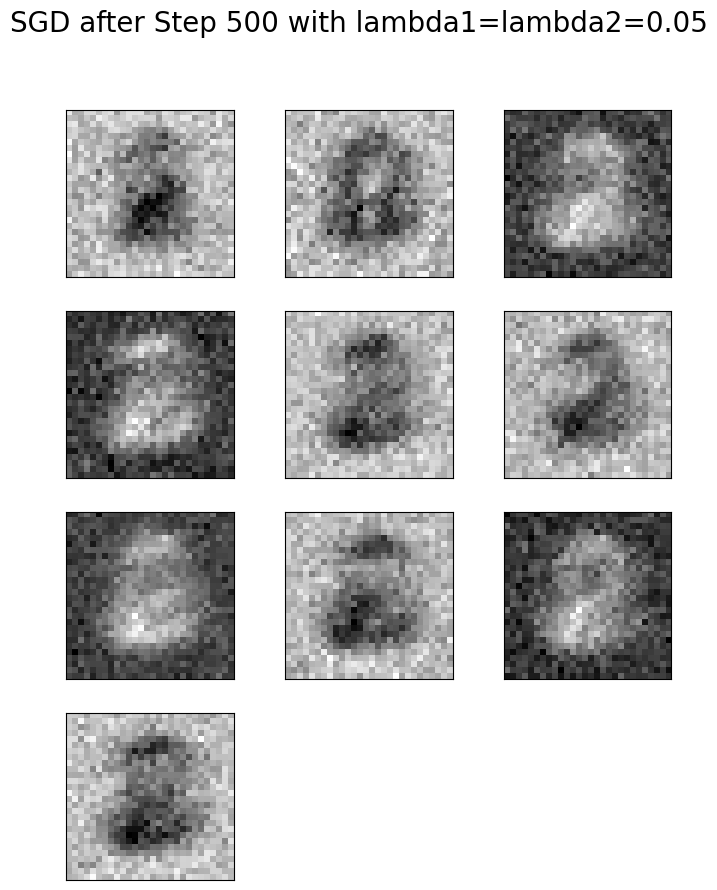

Minibatch loss at step 1000: 11989.316406
Minibatch accuracy: 92.6%
Validation accuracy: 89.9%


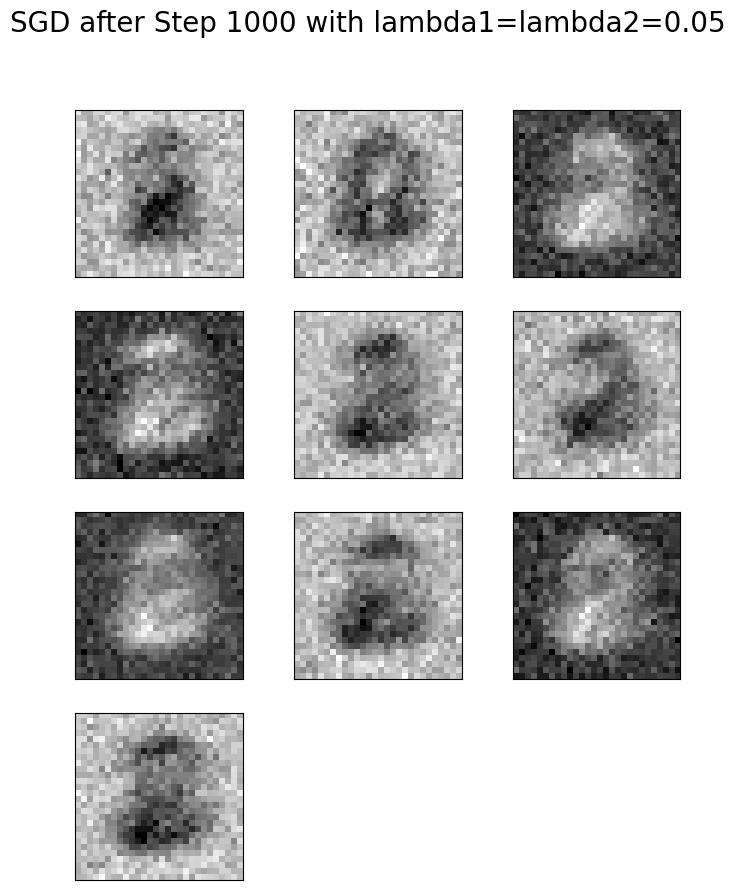

Minibatch loss at step 1500: 10312.201172
Minibatch accuracy: 96.5%
Validation accuracy: 90.2%


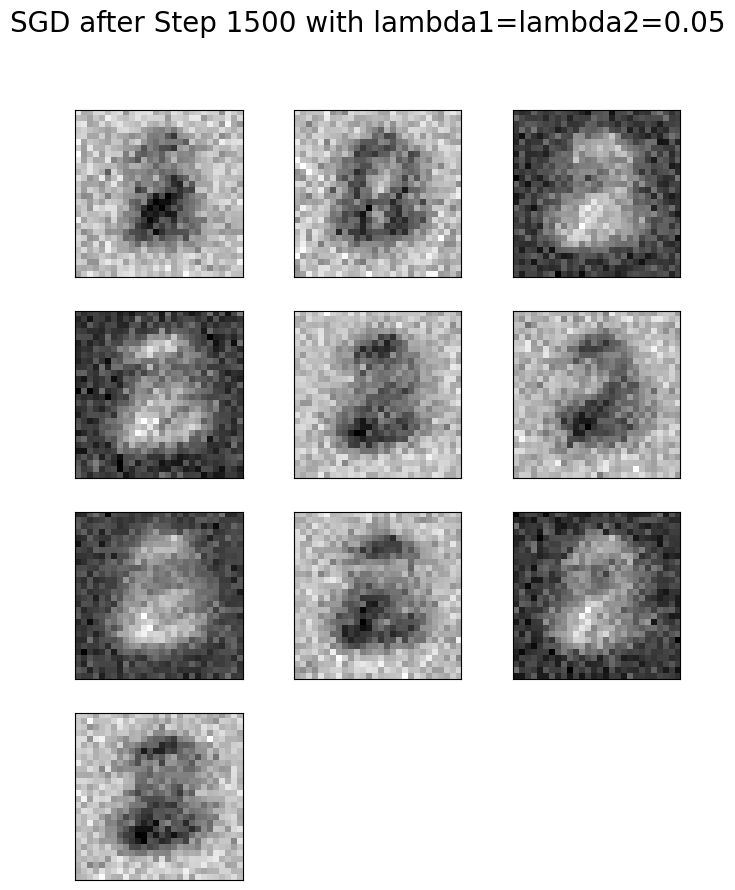

Minibatch loss at step 2000: 8862.839844
Minibatch accuracy: 96.9%
Validation accuracy: 90.5%


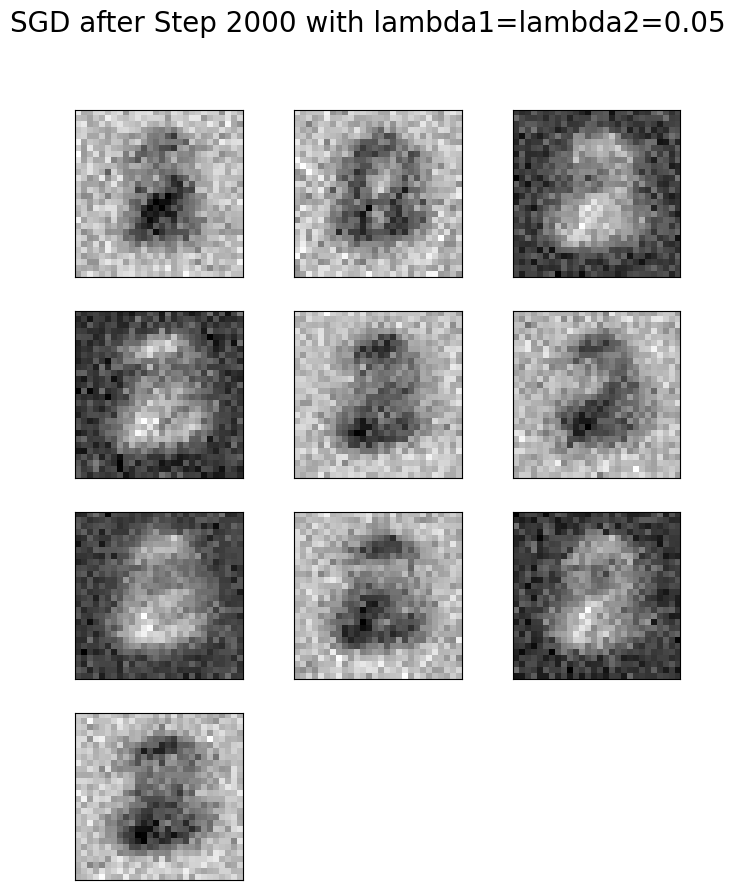

Minibatch loss at step 2500: 7627.728516
Minibatch accuracy: 96.5%
Validation accuracy: 90.3%


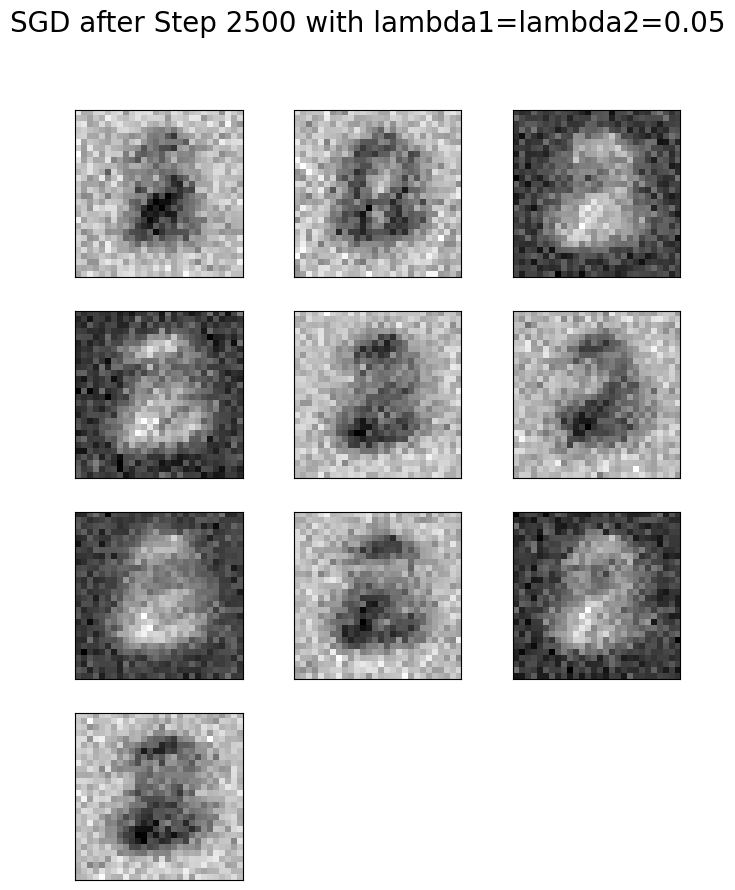

Minibatch loss at step 3000: 6566.754883
Minibatch accuracy: 96.5%
Validation accuracy: 90.6%


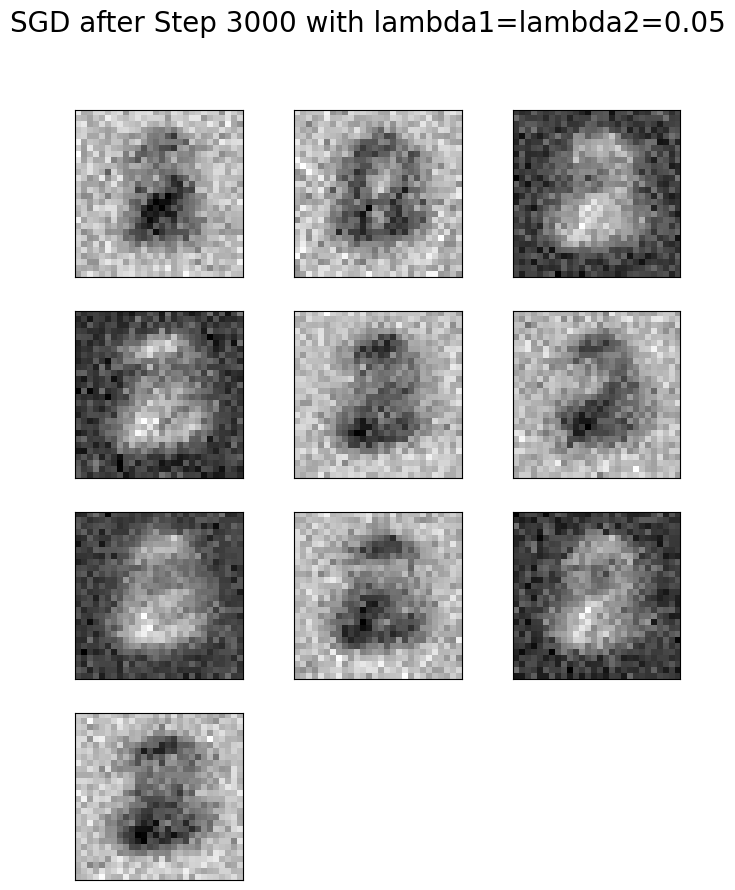

Minibatch loss at step 3500: 5651.245605
Minibatch accuracy: 99.2%
Validation accuracy: 90.5%


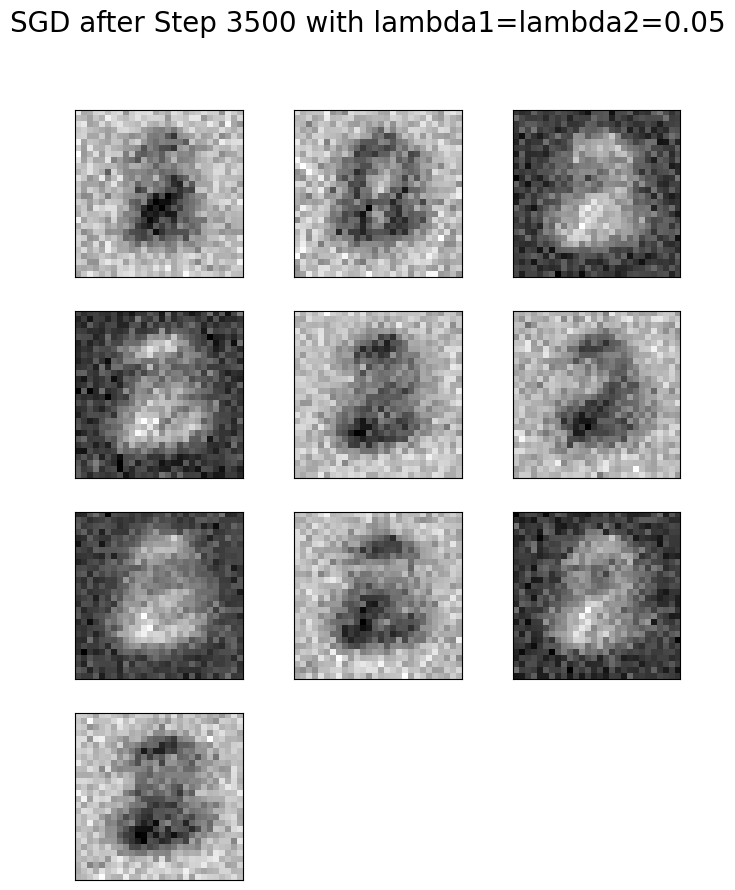

Minibatch loss at step 4000: 4863.249023
Minibatch accuracy: 96.9%
Validation accuracy: 90.7%


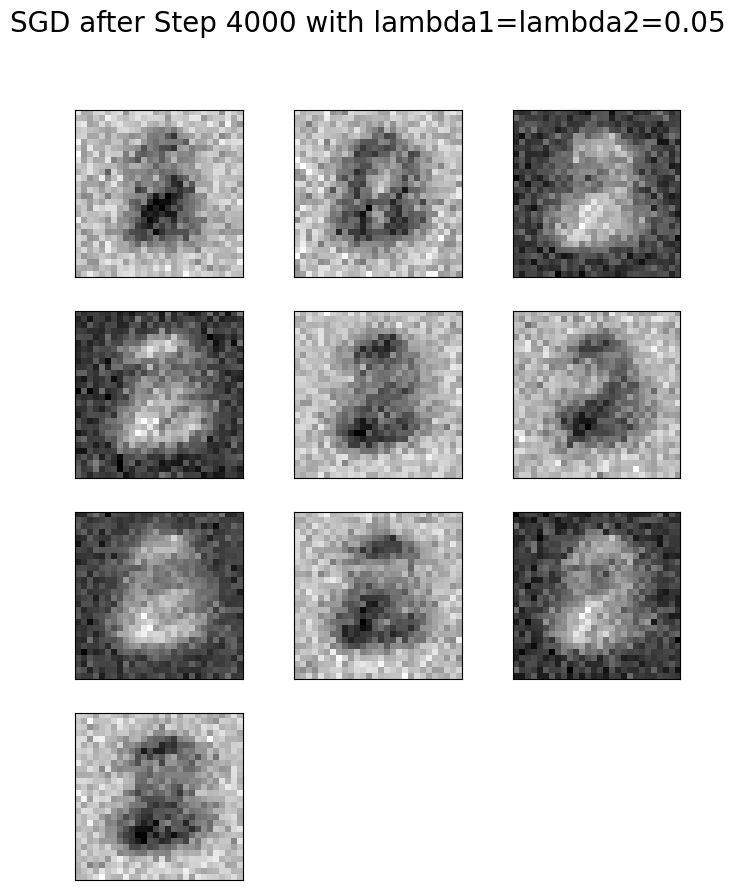

Minibatch loss at step 4500: 4185.355957
Minibatch accuracy: 98.0%
Validation accuracy: 90.5%


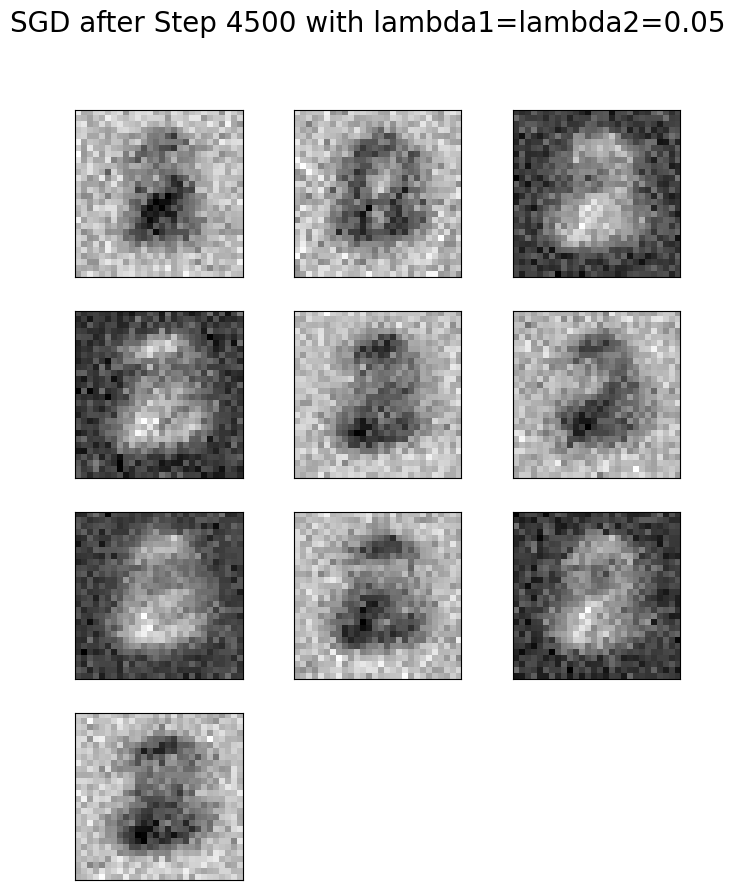

Minibatch loss at step 5000: 3602.305176
Minibatch accuracy: 98.0%
Validation accuracy: 90.7%


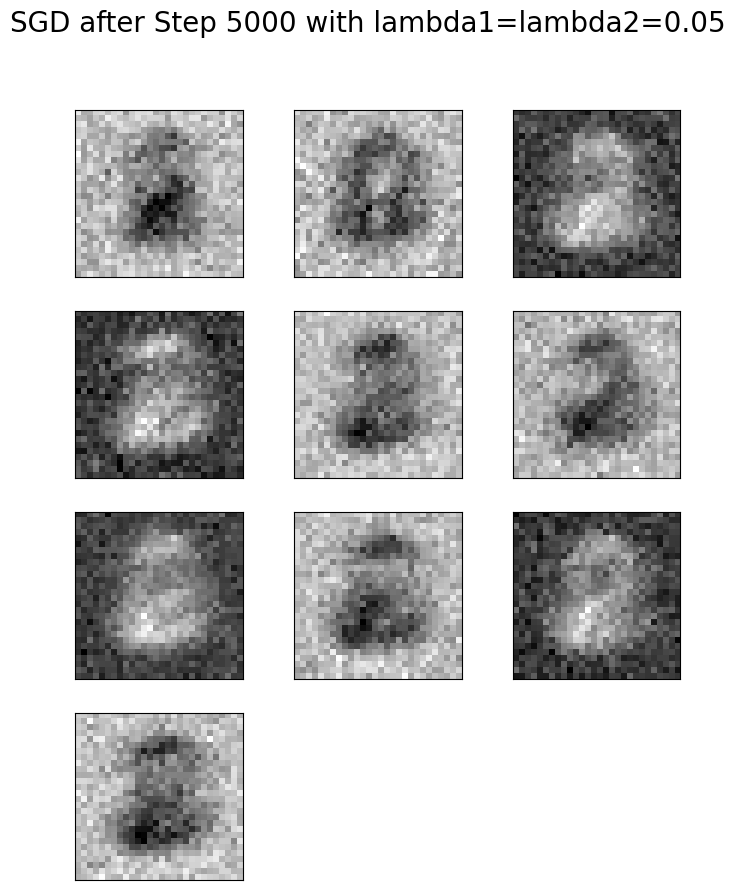

Minibatch loss at step 5500: 3100.563965
Minibatch accuracy: 97.3%
Validation accuracy: 90.4%


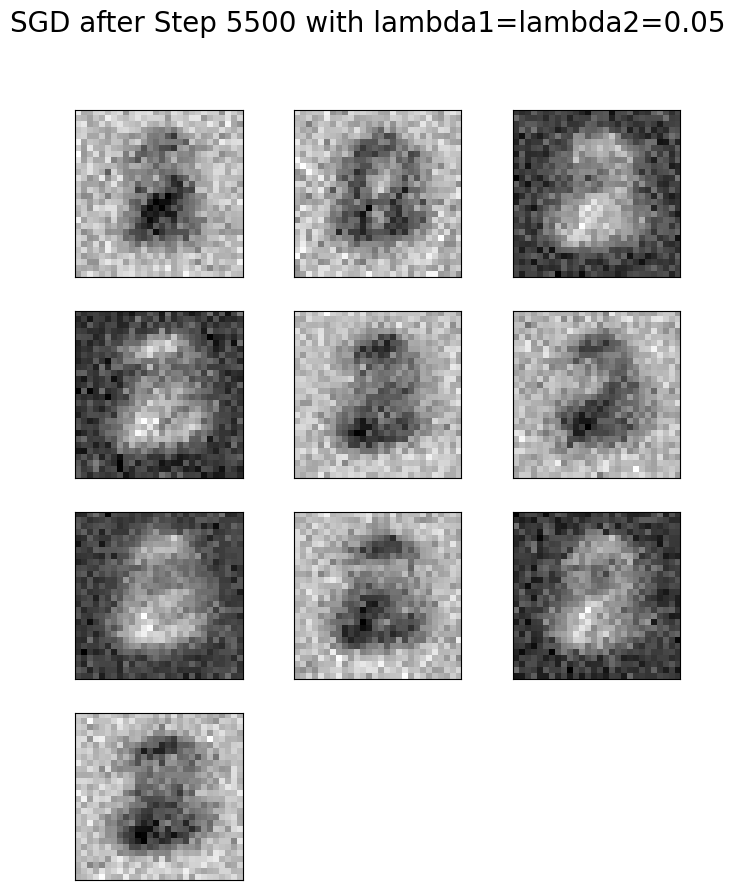

Minibatch loss at step 6000: 2668.579346
Minibatch accuracy: 99.2%
Validation accuracy: 90.6%


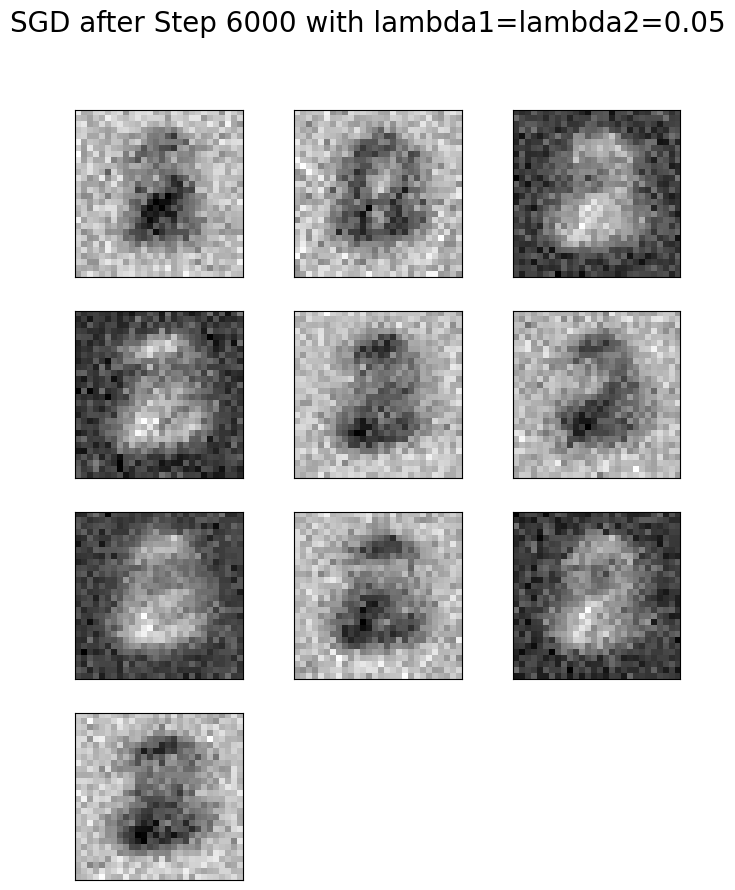

Test accuracy: 90.3%


In [7]:
num_steps = 6001                # số lượng bước huấn luyện

ll = []                         # lưu trữ giá trị mất mát
atr = []                        # lưu trữ độ chính xác trên tập huấn luyện
av = []                         # lưu trữ độ chính xác trên tập xác thực

import matplotlib.pylab as plt

# bắt đầu phiên làm việc TensorFLow
with tf.compat.v1.Session(graph=graph) as session:
  session.run(tf.compat.v1.global_variables_initializer())
  print("Initialized")
  for step in range(num_steps):
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)      # tính offset để lấy batch dữ liệu tiếp theo
    batch_data = X_train[offset:(offset + batch_size), :]               # lấy batch_data và batch_labels từ tập huấn luyện
    batch_labels = y_train[offset:(offset + batch_size), :]
    # thực hiện bước huấn luyện với dữ liệu batch, nhận về giá trị mất mát và dự đoán
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    # mỗi 500 bước, lưu trữ và in ra mất mát hiện tại, độ chính xác trên batch huấn luyện, độ chính xác trên tập xác thực
    if (step % 500 == 0):
      ll.append(l)
      a = accuracy(predictions, batch_labels)
      atr.append(a)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % a)
      a = accuracy(valid_prediction.eval(), y_valid)
      av.append(a)
      print("Validation accuracy: %.1f%%" % a)
      # tính toán và hiển thị biểu đồ của các trọng số để hiểu rõ hơn về quá trình học
      images = weights1.eval() @ weights2.eval()
      plt.figure(figsize=(8,10))
      for j in range(10):
        plt.subplot(4,3,j+1);plt.imshow(np.reshape(images[:,j], (image_size,image_size)), cmap='gray');
        plt.xticks([],[]);plt.yticks([],[])
      plt.suptitle('SGD after Step ' + str(step) + ' with lambda1=lambda2=' + str(lambda1), size=20)
      plt.savefig("SGD_after_Step_%s.png" % step)
      plt.show()
  # tính và in ra độ chính xác trên tập kiểm tra
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), y_test))

#### 6. Trực quan hóa kết quả huấn luyện

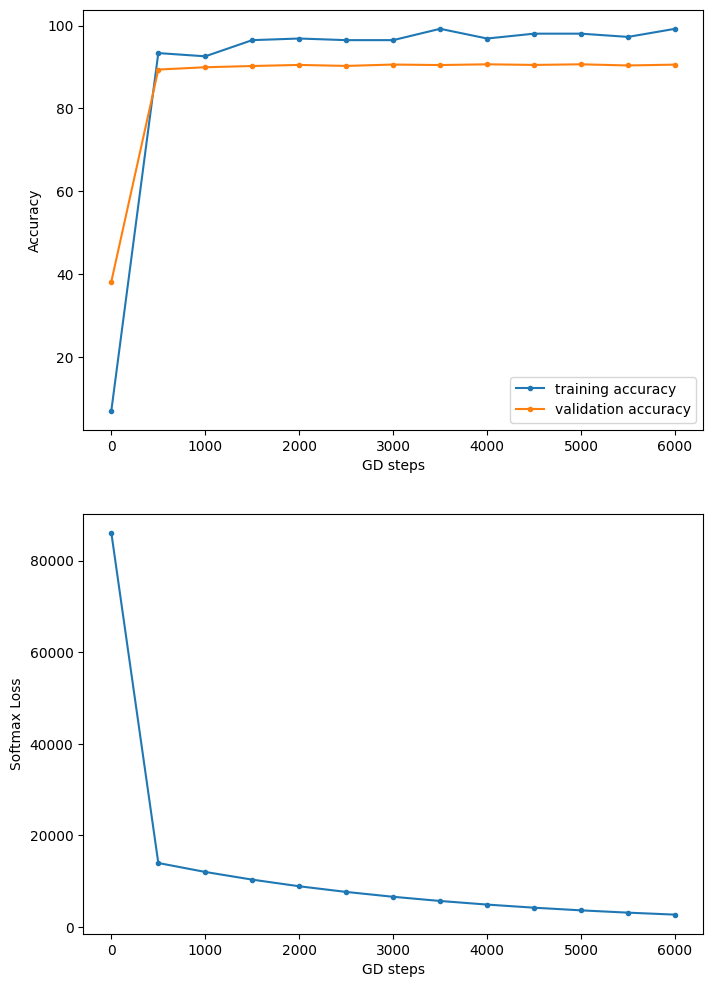

In [8]:
plt.figure(figsize=(8,12))
# so sánh độ chính xác trên tập huấn luyện và tập xác thực theo số bước huấn luyện
plt.subplot(211) 
plt.plot(range(0,6001,500), atr, '.-', label='training accuracy')
plt.plot(range(0,6001,500), av, '.-', label='validation accuracy')
plt.xlabel('GD steps')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
# hiển thị sự thay đổi của hàm mất mát trong quá trình huấn luyện
plt.subplot(212) 
plt.plot(range(0,6001,500), ll, '.-')
plt.xlabel('GD steps')
plt.ylabel('Softmax Loss')
plt.savefig('accuracy_softmax_loss.jpg')
plt.show()